In [1]:
#################### Loading necessary packages
import numpy as np
from numpy.polynomial import Polynomial

from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Data.psf import PSF
from lenstronomy.Util import simulation_util as sim_util
from lenstronomy.Util.param_util import phi_q2_ellipticity
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.ImSim.image_linear_solve import ImageLinearFit

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from astropy.cosmology import Planck15 as cosmo

import dynesty
import matplotlib.pyplot as plt

import json
 
# Opening JSON file
f = open('fordynesty/000_params.json')

# returns JSON object as 
# a dictionary
params = json.load(f)
 
# Iterating through the json
# list

z_lens = params['z']
z_source = 1.

lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)

/n/home13/atsang/.local/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
data000_r20_c60 = np.load('fordynesty/000_r20_c60.npy')

In [3]:
print(np.shape(data000_r20_c60))

(320, 320)


In [17]:
numPix2 = 320
deltaPix = 0.02

exp_time = 1.
sigma_bkg = 1.
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'
kwargs_psf = {'psf_type': psf_type,'fwhm':0.01}
psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1}
kwargs_data2 = sim_util.data_configure_simple(numPix2, deltaPix, exp_time, sigma_bkg)
data_class2 = ImageData(**kwargs_data2)

data_class2.update_data(data000_r20_c60)

/tmp/ipykernel_2852127/3441838910.py:14: RuntimeWarning: invalid value encountered in log10
  im0 = ax.matshow(np.log10(data000_r20_c60), origin='lower', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)


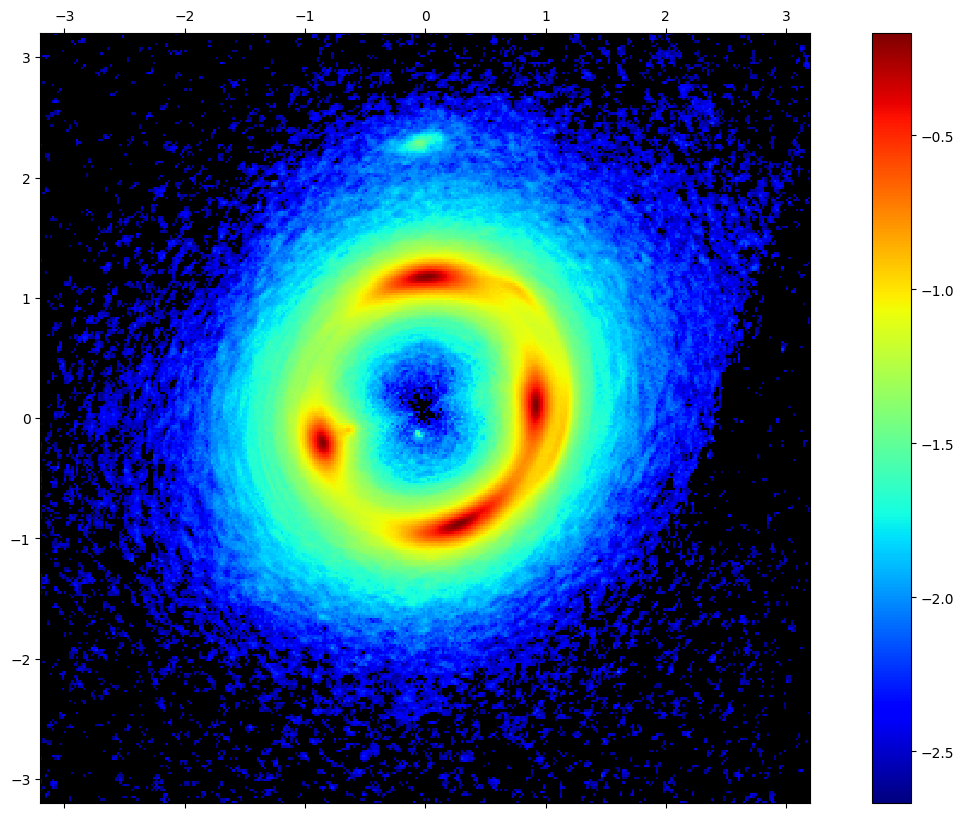

In [18]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

f, axes = plt.subplots(1, 1, figsize=(16,10), sharex=False, sharey=False)
ax = axes

vmin = np.log10(np.max(data000_r20_c60))-2.5
vmax = np.log10(np.max(data000_r20_c60))
ext = 0.5*numPix2*deltaPix
extent = [-ext,ext,-ext,ext]
#plt.plot(cv1ft,cv2ft,linewidth=2.,linestyle='solid',color='white')
im0 = ax.matshow(np.log10(data000_r20_c60), origin='lower', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
#im0 = ax.matshow(testimage1*likemask, origin='lower', vmin=vmin, vmax=vmax, cmap='jet',extent=extent)

f.colorbar(im0, ax=axes)

In [19]:
lens_model_list_new = ['SPEP','MULTIPOLE','MULTIPOLE','SHEAR','NFW']
lens_model_class = LensModel(lens_model_list=lens_model_list_new,z_source=z_source,z_lens=z_lens,multi_plane=False)

source_shape = ['SHAPELETS']
source_model_shape = LightModel(light_model_list=source_shape)

empty_light_model = LightModel([])
empty_light_param = []

imageModel = ImageLinearFit(data_class=data_class2, psf_class=psf_class, kwargs_numerics=kwargs_numerics, 
                            lens_model_class=lens_model_class, source_model_class=source_model_shape,
                            lens_light_model_class = empty_light_model,
                            likelihood_mask=np.ones([numPix2,numPix2]))

def model_with_shapelet(main_lens,multipole3,multipole4,shear,subhalo,kwargs_shapelet):
    
    kwargs_lens_model = [main_lens,multipole3,multipole4, shear, subhalo]
    wls_model, model_error, cov_param, coeffsq = imageModel.image_linear_solve(kwargs_lens_model, kwargs_shapelet, 
                                                                               kwargs_lens_light=empty_light_param, kwargs_ps=None, inv_bool=False)


    return wls_model, coeffsq

In [20]:
print(params)
print(params['main_theta'])
print(params['gamma'])

{'z': [0.5], 'gamma': 2.2151893663724196, 'phi_lens': 0.32284066732476147, 'q_lens': 0.7724415914984484, 'center_lens_x': -0.030538080264438106, 'center_lens_y': 0.058357645226662425, 'shear1': -0.0124825577474615, 'shear2': 0.07835460015641596, 'lens_a3': 0.018546510420041174, 'lens_phi3': -0.24411951211368066, 'lens_a4': 0.01166900152330658, 'lens_phi4': 0.04538803381089562, 'source_phi': -2.695259936440876, 'source_center_x': 0.027217824437572924, 'source_center_y': 0.17023865531706445, 'mass_sheets': True, 'x': [-0.8], 'y': [0.5], 'mass_multiplier': [0.3495945469927834], 'main_theta': 1.0195254015709299}
1.0195254015709299
2.2151893663724196


In [21]:
phi_lens = params['phi_lens']
q_lens = params['q_lens']

e1,e2 = phi_q2_ellipticity(phi_lens,q_lens)

main_lens = {"theta_E":params['main_theta'],
             "gamma":params['gamma'],
             "e1":e1,
             "e2":e2,
             "center_x":params['center_lens_x'],
             "center_y":params['center_lens_y']}

multipole3 = {"m":3,
                "a_m":params['lens_a3'],
                "phi_m":params['lens_phi3'],
                "center_x":params['center_lens_x'],
                "center_y":params['center_lens_y']}
multipole4 = {"m":4,
                "a_m":params['lens_a4'],
                "phi_m":params['lens_phi4'],
                "center_x":params['center_lens_x'],
                "center_y":params['center_lens_y']}

shear = {'gamma1':params['shear1'],
         'gamma2':params['shear2']}

mass = (10**9.5)*params['mass_multiplier'][0]
concen = 60
Rs_angle, alpha_Rs = lens_cosmo.nfw_physical2angle(M=mass, c=concen)

print(Rs_angle, alpha_Rs)
subhalo = {"Rs":Rs_angle, "alpha_Rs":alpha_Rs, "center_x":params['x'], "center_y":params['y']}

nmax = 50
delta = 1.2
kwargs_shapelet = [{"n_max":nmax , "beta":delta /np.power(nmax+1,0.5), "center_x":params['source_center_x'], "center_y":params['source_center_y']}]

[0.04809688] [0.00604958]


In [22]:
modelfit, coefs = model_with_shapelet(main_lens,multipole3,multipole4,shear,subhalo,kwargs_shapelet)

/tmp/ipykernel_2852127/3709925904.py:14: RuntimeWarning: invalid value encountered in log10
  im0 = ax.matshow(np.log10(modelfit), origin='lower', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)


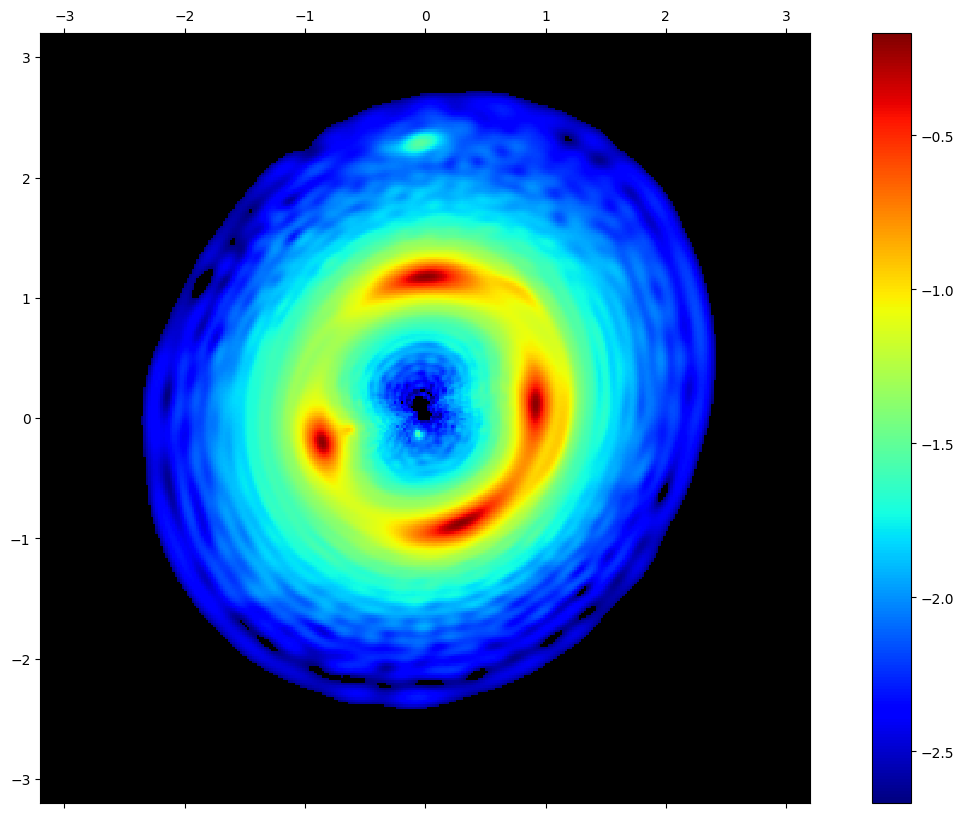

In [23]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

f, axes = plt.subplots(1, 1, figsize=(16,10), sharex=False, sharey=False)
ax = axes

vmin = np.log10(np.max(data000_r20_c60))-2.5
vmax = np.log10(np.max(data000_r20_c60))
ext = 0.5*numPix2*deltaPix
extent = [-ext,ext,-ext,ext]
#plt.plot(cv1ft,cv2ft,linewidth=2.,linestyle='solid',color='white')
im0 = ax.matshow(np.log10(modelfit), origin='lower', vmin=vmin, vmax=vmax, cmap=cmap,extent=extent)
#im0 = ax.matshow(testimage1*likemask, origin='lower', vmin=vmin, vmax=vmax, cmap='jet',extent=extent)

f.colorbar(im0, ax=axes)

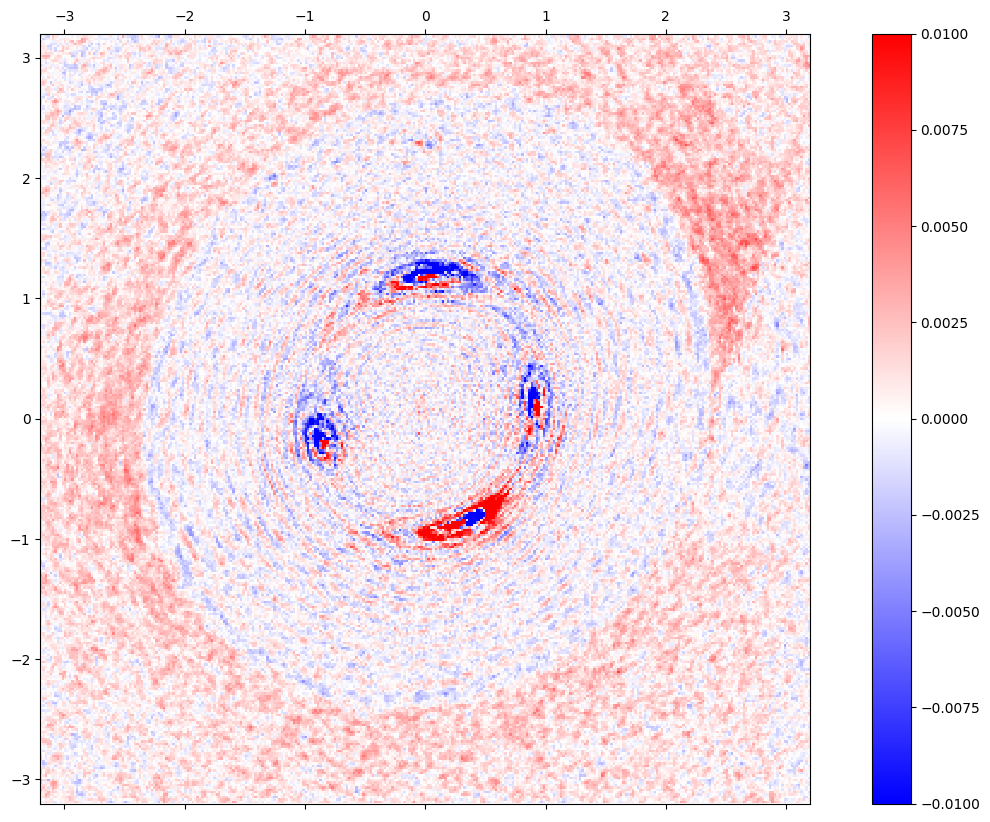

In [24]:
cmap_string = 'jet'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

f, axes = plt.subplots(1, 1, figsize=(16,10), sharex=False, sharey=False)
ax = axes

vmin = -0.01
vmax = 0.01
ext = 0.5*numPix2*deltaPix
extent = [-ext,ext,-ext,ext]
#plt.plot(cv1ft,cv2ft,linewidth=2.,linestyle='solid',color='white')
im0 = ax.matshow(data000_r20_c60-modelfit, origin='lower', vmin=vmin, vmax=vmax, cmap='bwr',extent=extent)
#im0 = ax.matshow(testimage1*likemask, origin='lower', vmin=vmin, vmax=vmax, cmap='jet',extent=extent)

f.colorbar(im0, ax=axes)